In [1]:
import numpy as np
from climada.hazard import TCTracks, TropCyclone, Centroids
from climada.entity import LitPop
from climada.entity import ImpactFuncSet, IFTropCyclone
from climada.engine import SupplyChain

2020-11-20 08:54:27,717 - climada - DEBUG - Loading default config file: C:\Users\aleciu\Documents\GitHub\climada_python\climada\conf\defaults.conf


C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


This tutorial shows how to use the `SupplyChain` class of CLIMADA. This class allows assessing indirect impacts via Inpu-Ouput modeling. Before diving into this class, it is highly recommended the user first familiarizes herself with the `Exposures`, `Hazard` and `Impact` classes.

# 1. Load Input-Output data.

At first, one needs to load Input Output data. Currently, the `SupplyChain` class loads data from the multi-regional input-output table (MRIOT) of the WIOD project (www.wiod.org).

In [2]:
supplychain = SupplyChain()
supplychain.read_wiot()

Let's now look at what data are now loaded into `SupplyChain`, i.e. modelled countries, sectors and IO data structure.

In [3]:
supplychain.countries

array(['Australia', 'Austria', 'Belgium', 'Bulgaria', 'Brazil', 'Canada',
       'Switzerland', 'China', 'Cyprus', 'Czechia', 'Germany', 'Denmark',
       'Spain', 'Estonia', 'Finland', 'France',
       'United Kingdom of Great Britain and Northern Ireland', 'Greece',
       'Croatia', 'Hungary', 'Indonesia', 'India', 'Ireland', 'Italy',
       'Japan', 'Korea, Republic of', 'Lithuania', 'Luxembourg', 'Latvia',
       'Mexico', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Russian Federation', 'Slovakia', 'Slovenia', 'Sweden',
       'Turkey', 'Taiwan, Province of China', 'United States of America',
       'Rest of World'], dtype='<U52')

In [4]:
supplychain.countries_iso3

array(['AUS', 'AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHN', 'CYP',
       'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC',
       'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'ITA', 'JPN', 'KOR', 'LTU',
       'LUX', 'LVA', 'MEX', 'MLT', 'NLD', 'NOR', 'POL', 'PRT', 'ROU',
       'RUS', 'SVK', 'SVN', 'SWE', 'TUR', 'TWN', 'USA', 'ROW'],
      dtype=object)

In [5]:
print(supplychain.countries_iso3.shape, supplychain.countries.shape)

(44,) (44,)


There are 43 countries plus 1. The additional "country" refers to all countries not explicitly modeled which are aggregated into a Rest of World (ROW) "country".

In [6]:
supplychain.sectors

array(['Crop and animal production, hunting and related service activities',
       'Forestry and logging', 'Fishing and aquaculture',
       'Mining and quarrying',
       'Manufacture of food products, beverages and tobacco products',
       'Manufacture of textiles, wearing apparel and leather products',
       'Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials',
       'Manufacture of paper and paper products',
       'Printing and reproduction of recorded media',
       'Manufacture of coke and refined petroleum products ',
       'Manufacture of chemicals and chemical products ',
       'Manufacture of basic pharmaceutical products and pharmaceutical preparations',
       'Manufacture of rubber and plastic products',
       'Manufacture of other non-metallic mineral products',
       'Manufacture of basic metals',
       'Manufacture of fabricated metal products, except machinery and equipment',
       

In [7]:
print(supplychain.sectors.shape)

(56,)


There are 56 economic sectors. These sectors can also be grouped into higher-level sectors. For instance, in the aftermath we will model the service sector which will include the following subsectors:

In [8]:
supplychain.sectors[range(26,56)]

array(['Construction',
       'Wholesale and retail trade and repair of motor vehicles and motorcycles',
       'Wholesale trade, except of motor vehicles and motorcycles',
       'Retail trade, except of motor vehicles and motorcycles',
       'Land transport and transport via pipelines', 'Water transport',
       'Air transport',
       'Warehousing and support activities for transportation',
       'Postal and courier activities',
       'Accommodation and food service activities',
       'Publishing activities',
       'Motion picture, video and television programme production, sound recording and music publishing activities; programming and broadcasting activities',
       'Telecommunications',
       'Computer programming, consultancy and related activities; information service activities',
       'Financial service activities, except insurance and pension funding',
       'Insurance, reinsurance and pension funding, except compulsory social security',
       'Activities auxiliar

Weather to aggregate sectors into main sectors and how to do it is up to the user, according to the application of interest and data availiability. Default settings are available in CLIMADA based on the built-in datasets.

In [9]:
supplychain.mriot_data

array([[12924.17969130469, 112.45422087923232, 228.48046203193053, ...,
        5.59127704802508, 0, 8.414460984686932e-07],
       [83.02963717643571, 201.49994833986213, 0.19131293060662055, ...,
        0.015955249114924915, 0, 1.7352453879104554e-08],
       [19.147730918389332, 0.0010789228629336921, 19.10670051105882,
        ..., 0.013536616205193624, 0, 1.639899869518615e-09],
       ...,
       [2.18792304737646, 0.0112367347152997, 0.12830516716781679, ...,
        16832.05585393637, 0, 0.7543988364004925],
       [0.0412177259444529, 3.5655491829230303e-06,
        0.00014960473042684668, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object)

In [10]:
supplychain.mriot_data.shape

(2464, 2464)

The MRIO table is a squared matrix with columns (and rows) equal to the number of economic sectors times the number of modeled countries, i.e. 56x44 = 2464. Each column (row) reports input (output) data of *all* sectors of *a given* country untill all countries are reported. Thus, if one wants to e.g. access the data of Switzerland, she can do:

In [11]:
# find position of Switzerland in list of countries
cntr_idx = np.where(supplychain.countries_iso3 == 'CHE')[0][0]
# infer position in table of first row for Switzerland
pos_in_table = cntr_idx*supplychain.n_sectors
# derive mriot data for all Swiss sectors
supplychain.mriot_data[range(pos_in_table, 
                             pos_in_table+supplychain.n_sectors)]

array([[0.3071732045628967, 0.0026753156980729416, 0.005442864663701143,
        ..., 0.14034255375207846, 0, 2.1120522787460625e-08],
       [3.038516375837506e-05, 4.634518238294213e-06,
        1.180264688491803e-06, ..., 0.0007335875074002841, 0,
        7.97827930906023e-10],
       [1.601084415618344e-06, 3.5214372177597135e-09,
        1.2809661212882726e-07, ..., 0.0023112265648541374, 0,
        2.7999465188930085e-10],
       ...,
       [0.008166435351466775, 4.887316753732749e-06,
        0.0002452574506838146, ..., 0.03257611735876409, 0,
        1.460034664996094e-06],
       [1.3166841803003427e-06, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object)

In [12]:
supplychain.total_prod

array([70292.03449229615, 2585.3796854828192, 3175.044396357493, ...,
       457353.44519941864, 19919.445712729233, 32.050552501236425],
      dtype=object)

In [13]:
print(supplychain.total_prod.shape)

(2464,)


Finally, total production data are available, i.e. sum of all productions, for each country-sector. Similarly as before, the total production of all Swiss sectors is:

In [14]:
supplychain.total_prod[range(pos_in_table, 
                             pos_in_table+supplychain.n_sectors)]

array([11791.462234393031, 782.9947235730398, 43.22362883144153,
       2011.6633347953796, 41513.176661806065, 3775.606183737862,
       9038.080466948333, 3537.891181616752, 3988.6212126150444,
       4522.7170729294085, 17019.02200241916, 83988.98576275684,
       8687.931554249948, 7882.680287565166, 5678.665439932978,
       20684.76785070759, 70747.84399719, 22410.032667732612,
       32910.51345567949, 2152.4837377489257, 5708.275210693812,
       12007.79973020708, 4950.845029257125, 45692.376833501374,
       5988.887697711592, 0, 84138.74128125056, 14030.31986145863,
       133902.8673299865, 43392.69347044904, 43977.95882668616,
       1100.507561005628, 14016.182671822728, 18112.03836010894,
       6232.756074949016, 25194.996936447966, 9971.056731292814, 0,
       18548.00677114938, 30136.177471812698, 66698.9138777453,
       45618.21343781693, 0, 69413.85474216571, 66586.20782156626, 0,
       20289.31241447955, 0, 9501.104322113943, 32947.952539168204,
       67749.3202

# 2. Define Hazard, Exposure and Vulnerability

Let's now define hazard, exposure and vulnerability. This is handled via the related CLIMADA classes. In this tutorial we use `LitPop` for exposure and `TropCyclone` for hazard. We will focus in particular on the impact of tropical cyclones affecting the Philippines, Taiwan, Vietnam and Japan between 2005 and 2010. Japan and Taiwan are modeled explicitely by the MRIO table, while the Philippines and Vietnam are modeled as Rest of World, they are thus aggregated into a single country.

In [15]:
countries = ['PHL', 'TWN', 'VNM', 'JPN']
exp_lp = LitPop()
exp_lp.set_country(countries, res_km=5.)
exp_lp.set_geometry_points()

2020-11-20 08:57:23,594 - climada.entity.exposures.litpop - WARNING - Not one of the legacy resoultions selected. Consider                        adjusting it to 120 arc-sec.
2020-11-20 08:57:34,214 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 150.0 arcsec.
2020-11-20 08:57:34,214 - climada.entity.exposures.litpop - WARNING - Not one of the legacy resoultions selected. Consider                        adjusting it to 120 arc-sec.
2020-11-20 08:57:42,413 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2020-11-20 08:57:42,413 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2020-11-20 08:58:31,888 - climada.util.finance - INFO - GDP JPN 2014: 4.850e+12.
2020-11-20 08:58:32,398 - climada.util.finance - INFO - GDP JPN 2016: 4.923e+12.
2020-11-20 08:58:33,007 - climada.util.finance - INFO - GDP VNM 2014: 1.862e+11.
2020-11-20 08:58:33,524 - climada.util.fina

C:\Users\aleciu\Documents\GitHub\climada_python\climada\util\plot.py:314: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\cartopy\mpl\feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))


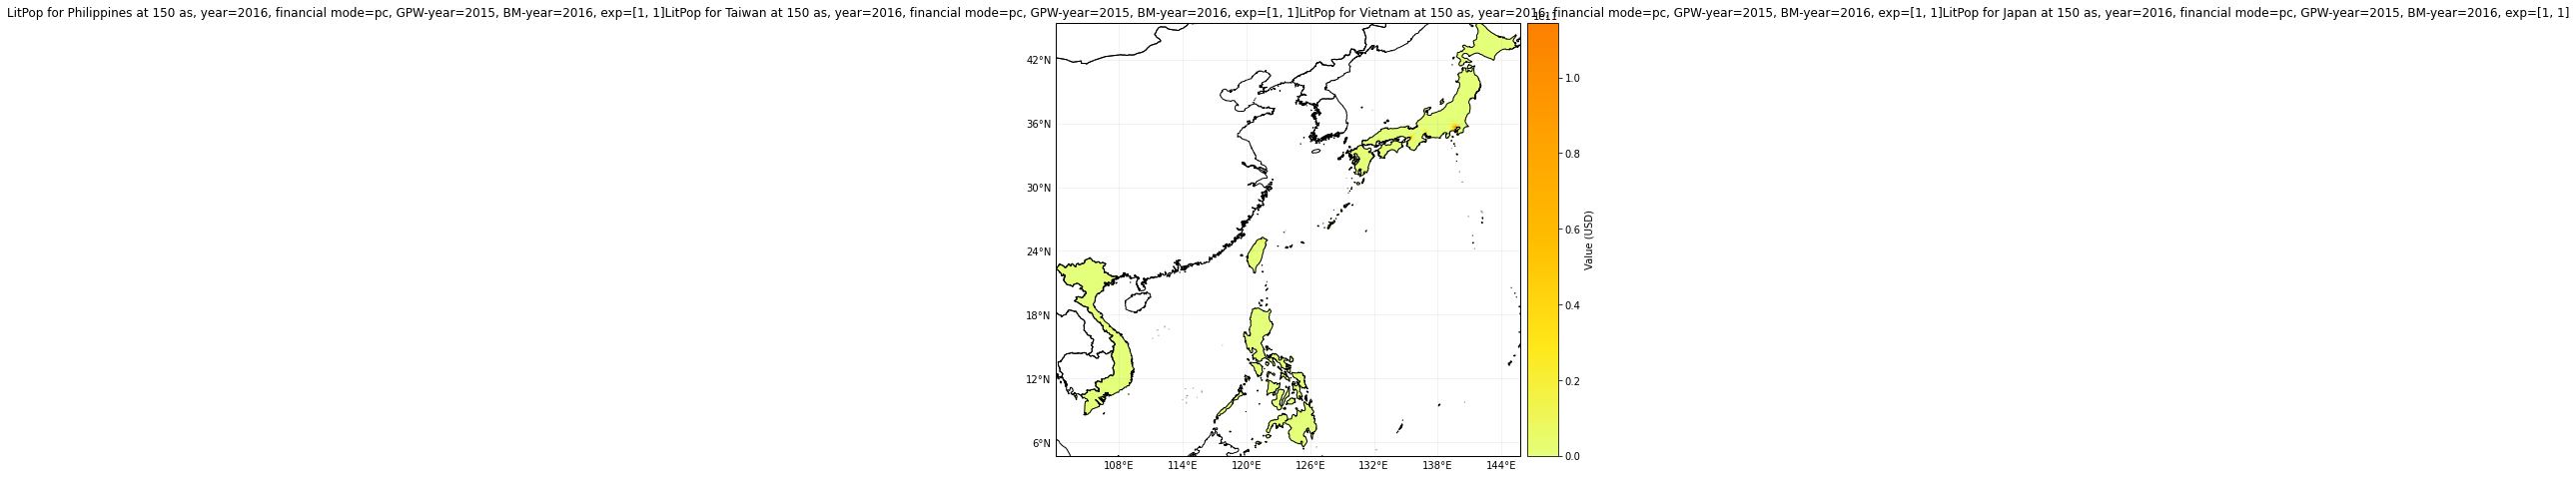

In [16]:
exp_lp.plot_hexbin(pop_name=False)

In [17]:
tc_tracks=TCTracks()
tc_tracks.read_ibtracs_netcdf(year_range=(2005,2010), basin='WP')

2020-11-20 09:00:08,912 - climada.hazard.tc_tracks - INFO - Progress: 10%
2020-11-20 09:00:09,929 - climada.hazard.tc_tracks - INFO - Progress: 20%
2020-11-20 09:00:10,932 - climada.hazard.tc_tracks - INFO - Progress: 30%
2020-11-20 09:00:12,040 - climada.hazard.tc_tracks - INFO - Progress: 40%
2020-11-20 09:00:13,101 - climada.hazard.tc_tracks - INFO - Progress: 51%
2020-11-20 09:00:13,851 - climada.hazard.tc_tracks - INFO - Progress: 61%
2020-11-20 09:00:15,218 - climada.hazard.tc_tracks - INFO - Progress: 71%
2020-11-20 09:00:16,466 - climada.hazard.tc_tracks - INFO - Progress: 81%
2020-11-20 09:00:17,911 - climada.hazard.tc_tracks - INFO - Progress: 92%


C:\Users\aleciu\Documents\GitHub\climada_python\climada\util\plot.py:314: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\cartopy\mpl\feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))


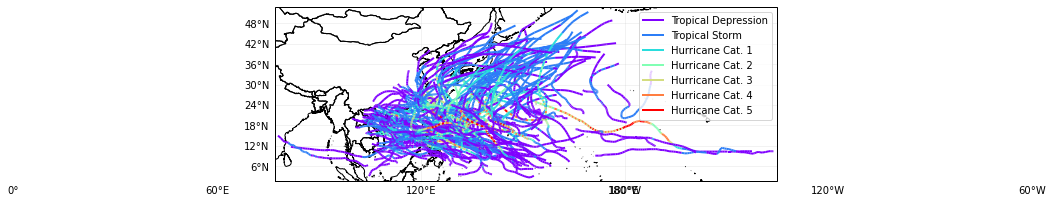

In [18]:
tc_tracks.plot()

In [19]:
centr=Centroids()
centr.set_lat_lon(exp_lp.latitude.values, exp_lp.longitude.values)

In [20]:
tc_cyclone = TropCyclone()
tc_cyclone.set_from_tracks(tracks=tc_tracks, centroids=centr)

2020-11-20 09:01:10,616 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2020-11-20 09:01:25,153 - climada.util.coordinates - INFO - dist_to_coast: UTM 32648 (1/8)


C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2020-11-20 09:01:47,479 - climada.util.coordinates - INFO - dist_to_coast: UTM 32649 (2/8)


C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2020-11-20 09:01:56,437 - climada.util.coordinates - INFO - dist_to_coast: UTM 32650 (3/8)


C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2020-11-20 09:02:03,556 - climada.util.coordinates - INFO - dist_to_coast: UTM 32651 (4/8)


C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2020-11-20 09:02:21,292 - climada.util.coordinates - INFO - dist_to_coast: UTM 32652 (5/8)


C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2020-11-20 09:02:32,071 - climada.util.coordinates - INFO - dist_to_coast: UTM 32653 (6/8)


C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2020-11-20 09:02:42,745 - climada.util.coordinates - INFO - dist_to_coast: UTM 32654 (7/8)


C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2020-11-20 09:02:57,771 - climada.util.coordinates - INFO - dist_to_coast: UTM 32655 (8/8)


C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2020-11-20 09:02:58,867 - climada.hazard.trop_cyclone - INFO - Mapping 166 tracks to 53910 centroids.
2020-11-20 09:03:22,262 - climada.hazard.trop_cyclone - INFO - Progress: 10%
2020-11-20 09:03:50,444 - climada.hazard.trop_cyclone - INFO - Progress: 20%
2020-11-20 09:04:13,720 - climada.hazard.trop_cyclone - INFO - Progress: 30%
2020-11-20 09:04:35,948 - climada.hazard.trop_cyclone - INFO - Progress: 40%
2020-11-20 09:04:51,728 - climada.hazard.trop_cyclone - INFO - Progress: 51%
2020-11-20 09:05:12,387 - climada.hazard.trop_cyclone - INFO - Progress: 61%
2020-11-20 09:05:33,027 - climada.hazard.trop_cyclone - INFO - Progress: 71%
2020-11-20 09:05:59,973 - climada.hazard.trop_cyclone - INFO - Progress: 81%
2020-11-20 09:06:14,256 - climada.hazard.trop_cyclone - INFO - Progress: 92%


C:\Users\aleciu\Documents\GitHub\climada_python\climada\util\plot.py:314: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


C:\Users\aleciu\Anaconda3\envs\climada_env\lib\site-packages\cartopy\mpl\feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))


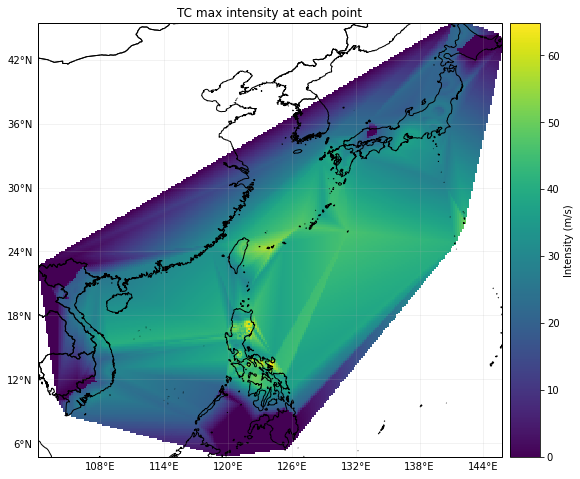

In [21]:
tc_cyclone.plot_intensity(event=0)

In [22]:
impf_tc= IFTropCyclone()
impf_tc.set_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet()
impf_set.append(impf_tc)
impf_set.check()

2020-11-20 09:06:40,203 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


In [23]:
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]

# Exposures: rename column and assign id
exp_lp.rename(columns={"if_": "if_" + haz_type}, inplace=True)
exp_lp['if_' + haz_type] = haz_id
exp_lp.check()

2020-11-20 09:06:40,239 - climada.entity.exposures.base - INFO - centr_ not set.
2020-11-20 09:06:40,242 - climada.entity.exposures.base - INFO - deductible not set.
2020-11-20 09:06:40,244 - climada.entity.exposures.base - INFO - cover not set.
2020-11-20 09:06:40,245 - climada.entity.exposures.base - INFO - category_id not set.


# 3. Calculate direct, indirect and total impact per sector and country

Let's now calculate direct, indirect and total impacts. For the **direct impact**, `SupplyChain` requires as inputs `Hazard`, `Exposures` and `ImpactFuncSet`. In addition, one needs to specify either `sector_type` or `sec_subsec`. The former works for CLIMADA's built-in IO settings and it is a tring that can be either "service", "manufacturing", "agriculture" or "mining". The latter allows the user to define her own aggregation of subsectors into sectors. 

For this tutorial, we will model the service sector, as this sector's exposure can be reasonably be modeled via nighlights and population data, i.e. via `LitPop`.

## 3.1 Direct impact

In [24]:
supplychain.calc_sector_direct_impact(tc_cyclone, exp_lp, impf_set, sector_type='service')

2020-11-20 09:06:40,285 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-11-20 09:06:40,301 - climada.entity.exposures.base - INFO - centr_ not set.
2020-11-20 09:06:40,301 - climada.entity.exposures.base - INFO - deductible not set.
2020-11-20 09:06:40,301 - climada.entity.exposures.base - INFO - cover not set.
2020-11-20 09:06:40,308 - climada.entity.exposures.base - INFO - category_id not set.
2020-11-20 09:06:40,316 - climada.entity.exposures.base - INFO - Matching 13993 exposures with 53910 centroids.
2020-11-20 09:06:44,112 - climada.engine.impact - INFO - Calculating damage for 13784 assets (>0) and 166 events.
2020-11-20 09:06:44,377 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-11-20 09:06:44,379 - climada.entity.exposures.base - INFO - centr_ not set.
2020-11-20 09:06:44,382 - climada.entity.exposures.base - INFO - deductible not set.
2020-11-20 09:06

Let's see what new attributes the class has got now.

In [25]:
supplychain.direct_impact

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.63402913e+01, 5.51858045e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.79007426e+03, 3.30638608e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.30941749e+00, 1.11768428e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.05361728e+03, 6.93564865e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.22251587e+01, 1.42606354e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.33858181e+02, 1.12753388e+01, 0.00000000e+00]])

In [26]:
supplychain.direct_impact.shape

(6, 2464)

All impact matrixes (also those below) provide impacts aggregated over years. They have a number of rows equal to the years being modeled (6 years this time, i.e. 2005-2010) and columns equal to the number of countries times the number of sectors.

In [27]:
supplychain.direct_aai_agg

array([   0.        ,    0.        ,    0.        , ..., 2039.90409704,
         68.89335383,    0.        ])

In [28]:
supplychain.direct_aai_agg.shape

(2464,)

The yearly aggregated impact matrixes provide the yearly average impact. They are row vectors with columns equal to the number of countries x the number of sectors.

Info for a given country can be accessed using the values of the dictionary below:

In [29]:
supplychain.values_pos

{'ROW': range(2434, 2464), 'TWN': range(2322, 2352), 'JPN': range(1370, 1400)}

which contains the positions in the matrix of values for each modeled country. If you want to build a list with positions of all modeled countries, do e.g.:

In [30]:
pos_all = []
for val in supplychain.values_pos.values():
    pos_all.extend(val)

In [31]:
print(supplychain.direct_impact.sum(), supplychain.direct_impact[:, pos_all].sum())

338120.5936754274 338120.59367542743


In [32]:
print(supplychain.direct_aai_agg.sum(), supplychain.direct_aai_agg[pos_all].sum())

56353.432279237895 56353.432279237895


Obviusly, the matrix only has non-zero values in correspondence of the modeled countries. 

## 3.2 Indirect impact

For the **indirect impact**, one can choose the IO modeling approach between Leontief, Ghosh and EEIOA. References are provided below:

In [33]:
supplychain.calc_indirect_impact?

Signature: supplychain.calc_indirect_impact(io_approach='ghosh')
Docstring:
Estimate indirect impact based on direct impact using input-output (IO)
methodology. There are three IO approaches to choose from (see Parameters).
    [1] Standard Input-Output (IO) Model;
        W. W. Leontief, Output, employment, consumption, and investment,
        The Quarterly Journal of Economics 58 (2) 290?314, 1944
    [2] Ghosh Model;
        Ghosh, A., Input-Output Approach in an Allocation System,
        Economica, New Series, 25, no. 97: 58-64. doi:10.2307/2550694, 1958
    [3] Environmentally Extended Input-Output Analysis (EEIOA);
        Kitzes, J., An Introduction to Environmentally-Extended Input-Output Analysis,
        Resources 2013, 2, 489-503; doi:10.3390/resources2040489, 2013
Parameters:
    io_approach (str): string specifying which IO approach the user would
        like to use. Either 'leontief', 'ghosh' (default) or 'eeioa'.
File:      c:\users\aleciu\documents\github\climada_pyth

Let's calculate indirect impacts according to the Ghosh method:

In [34]:
supplychain.calc_indirect_impact(io_approach='ghosh')

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]


The class now has the indirect impact matrix and vector, with structure equal to those introduced for the direct impact:

In [35]:
supplychain.indirect_impact

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.4940027e+01,
        8.6868942e-01, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 8.9511250e+03,
        5.2046399e+02, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.0258205e+00,
        1.7593664e-01, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.8776349e+03,
        1.0917526e+02, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.8606720e+01,
        2.2447915e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.0524854e+02,
        1.7748709e+01, 0.0000000e+00]], dtype=float32)

In [36]:
supplychain.indirect_impact.shape

(6, 2464)

In [37]:
supplychain.indirect_aai_agg

array([   0.     ,    0.     ,    0.     , ..., 1865.0967 ,  108.44625,
          0.     ], dtype=float32)

But it also got coefficients, inverse matrix and risk matrix based on the selected IO approach:

In [38]:
supplychain.io_data

{'coefficients': array([[1.8386407e-01, 1.5998146e-03, 3.2504459e-03, ..., 7.9543534e-05,
         0.0000000e+00, 1.1970718e-11],
        [3.2115065e-02, 7.7938244e-02, 7.3998002e-05, ..., 6.1713367e-06,
         0.0000000e+00, 6.7117622e-12],
        [6.0306969e-03, 3.3981348e-07, 6.0177743e-03, ..., 4.2634415e-06,
         0.0000000e+00, 5.1649668e-13],
        ...,
        [4.7838780e-06, 2.4569038e-08, 2.8053833e-07, ..., 3.6803167e-02,
         0.0000000e+00, 1.6494876e-06],
        [2.0692205e-06, 1.7899841e-10, 7.5104865e-09, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32),
 'inverse': array([[1.24074233e+00, 2.19719345e-03, 4.40222956e-03, ...,
         1.72480312e-03, 0.00000000e+00, 1.24720373e-07],
        [5.89840598e-02, 1.08470321e+00, 5.51104255e-04, ...,
         1.69067783e-03, 0.00000000e+00, 1.44200243e-07],
        [1.41618615

## 3.3 Total impact

Finally, let's calculate **total impacts**, as the sum of both direct and indirect. Therefore, the impact matrixes have the same structure as the direct and indirect matrixes.

In [39]:
supplychain.calc_total_impact()

In [40]:
supplychain.total_impact

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.12803185e+01, 1.42054746e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.87411993e+04, 8.51102597e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.33523798e+00, 2.87705068e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.93125217e+03, 1.78531749e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.08318787e+01, 3.67085505e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.39106716e+02, 2.90240475e+01, 0.00000000e+00]])

In [41]:
supplychain.total_aai_agg

array([   0.       ,    0.       ,    0.       , ..., 3905.0009288,
        177.3395835,    0.       ])